In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================
# SVM CLASSIFICATION FOR YOUR OWN IMAGE DATASET
# Complete Code for Google Colab
# ============================================

# Install libraries
!pip install scikit-learn opencv-python matplotlib seaborn pillow numpy scikit-image -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
from PIL import Image
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from skimage.feature import hog
from google.colab import files, drive
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("SVM IMAGE CLASSIFICATION - YOUR CUSTOM DATASET")
print("="*70)

# ============================================
# METHOD 1: Upload ZIP File Directly to Colab
# ============================================

def upload_and_extract_zip():
    """
    Upload a zip file containing your image dataset

    Expected folder structure inside zip:
    dataset.zip
      ├── class1/
      │   ├── image1.jpg
      │   ├── image2.jpg
      ├── class2/
      │   ├── image1.jpg
      │   ├── image2.jpg
    """
    print("\n✓ Upload your dataset ZIP file...")
    uploaded = files.upload()

    zip_filename = list(uploaded.keys())[0]
    print(f"\n✓ Extracting {zip_filename}...")

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')

    print("✓ Extraction complete!")

    # Find the extracted folder
    extracted_folders = os.listdir('dataset')
    if len(extracted_folders) == 1:
        dataset_path = os.path.join('dataset', extracted_folders[0])
    else:
        dataset_path = 'dataset'

    return dataset_path

# ============================================
# METHOD 2: Mount Google Drive
# ============================================

def mount_google_drive():
    """
    Mount Google Drive to access your dataset

    Steps:
    1. Upload your dataset folder to Google Drive
    2. Run this function
    3. Provide the path to your dataset folder
    """
    print("\n✓ Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully!")
    print("\nYour Google Drive path: /content/drive/MyDrive/")
    print("\nExample: If your dataset is at 'My Drive/my_dataset/'")
    print("Enter: /content/drive/MyDrive/my_dataset")

    return '/content/drive/MyDrive/'

# ============================================
# METHOD 3: Direct Upload (for small datasets)
# ============================================

def upload_images_directly():
    """
    Upload images directly (suitable for small datasets < 100 images)
    You'll need to manually assign labels
    """
    print("\n✓ Upload your images...")
    uploaded = files.upload()

    images = []
    filenames = []

    for filename in uploaded.keys():
        img = Image.open(filename)
        img = img.convert('RGB')
        img_array = np.array(img)
        images.append(img_array)
        filenames.append(filename)

    return np.array(images), filenames

# ============================================
# LOAD IMAGES FROM FOLDER STRUCTURE
# ============================================

def load_images_from_folder(folder_path, img_size=(128, 128), max_images_per_class=None):
    """
    Load images from folder structure:

    folder_path/
      ├── class1/
      │   ├── img1.jpg
      │   ├── img2.jpg
      ├── class2/
      │   ├── img1.jpg
      │   ├── img2.jpg

    Parameters:
    - folder_path: path to main folder containing class subfolders
    - img_size: resize all images to this size (width, height)
    - max_images_per_class: limit number of images per class (None = load all)
    """
    print(f"\n✓ Loading images from: {folder_path}")
    print(f"  Target size: {img_size}")

    images = []
    labels = []
    class_names = []
    image_paths = []

    # Get all class folders
    class_folders = [f for f in os.listdir(folder_path)
                     if os.path.isdir(os.path.join(folder_path, f))]

    if len(class_folders) == 0:
        raise ValueError(f"No class folders found in {folder_path}")

    class_folders.sort()
    print(f"\n  Found {len(class_folders)} classes: {class_folders}")

    # Load images from each class
    for class_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_name)
        class_names.append(class_name)

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Limit images per class if specified
        if max_images_per_class:
            image_files = image_files[:max_images_per_class]

        loaded_count = 0
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                # Load and preprocess image
                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Resize image
                img = cv2.resize(img, img_size)

                images.append(img)
                labels.append(class_name)
                image_paths.append(img_path)
                loaded_count += 1

            except Exception as e:
                print(f"  Error loading {img_path}: {e}")

        print(f"  ✓ {class_name}: Loaded {loaded_count} images")

    images = np.array(images)
    labels = np.array(labels)

    print(f"\n✓ Total images loaded: {len(images)}")
    print(f"  Image shape: {images[0].shape}")
    print(f"  Classes: {class_names}")

    return images, labels, class_names, image_paths

# ============================================
# VISUALIZE DATASET
# ============================================

def visualize_dataset(images, labels, class_names, n_samples=16):
    """
    Display sample images from the dataset
    """
    print(f"\n✓ Visualizing {n_samples} random samples...")

    # Select random samples
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        if i >= rows * cols:
            break

        img = images[idx]
        label = labels[idx]

        # Convert BGR to RGB for display
        if len(img.shape) == 3:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_display = img

        axes[i].imshow(img_display)
        axes[i].set_title(f'{label}', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, class_names):
    """
    Plot distribution of classes in dataset
    """
    from collections import Counter

    label_counts = Counter(labels)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(label_counts.keys(), label_counts.values(), color='steelblue')
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n✓ Class Distribution:")
    for class_name, count in sorted(label_counts.items()):
        print(f"  {class_name}: {count} images")

# ============================================
# FEATURE EXTRACTION FOR YOUR IMAGES
# ============================================

def extract_features(images, method='hog'):
    """
    Extract features from your images

    Methods:
    - 'hog': Histogram of Oriented Gradients (best for shapes/objects)
    - 'histogram': Color histogram (best for color-based classification)
    - 'combined': Both HOG and histogram
    - 'raw': Raw pixel values (fastest but least accurate)
    """
    print(f"\n✓ Extracting features using '{method}' method...")

    if method == 'hog':
        features = []
        for img in images:
            # Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img

            # Extract HOG features
            feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, feature_vector=True)
            features.append(feat)

        features = np.array(features)

    elif method == 'histogram':
        features = []
        for img in images:
            if len(img.shape) == 3:
                hist_b = cv2.calcHist([img], [0], None, [32], [0, 256])
                hist_g = cv2.calcHist([img], [1], None, [32], [0, 256])
                hist_r = cv2.calcHist([img], [2], None, [32], [0, 256])
                feat = np.concatenate([hist_b, hist_g, hist_r]).flatten()
            else:
                hist = cv2.calcHist([img], [0], None, [32], [0, 256])
                feat = hist.flatten()
            features.append(feat)

        features = np.array(features)

    elif method == 'combined':
        hog_feat = extract_features(images, method='hog')
        hist_feat = extract_features(images, method='histogram')
        features = np.concatenate([hog_feat, hist_feat], axis=1)

    elif method == 'raw':
        features = images.reshape(len(images), -1)

    else:
        raise ValueError("Invalid method. Choose: 'hog', 'histogram', 'combined', 'raw'")

    print(f"  Feature shape: {features.shape}")
    return features

# ============================================
# TRAIN SVM ON YOUR DATASET
# ============================================

def train_svm_on_custom_dataset(images, labels, class_names,
                                feature_method='hog',
                                use_pca=True,
                                pca_components=100,
                                test_size=0.2,
                                use_grid_search=True):
    """
    Complete training pipeline for your custom dataset
    """
    print("\n" + "="*70)
    print("TRAINING SVM ON YOUR DATASET")
    print("="*70)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    print(f"\n✓ Classes: {class_names}")
    print(f"  Total samples: {len(images)}")

    # Extract features
    X = extract_features(images, method=feature_method)

    # Split data
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, range(len(X)), test_size=test_size, random_state=42, stratify=y
    )

    print(f"\n✓ Data split:")
    print(f"  Training: {len(X_train)} samples")
    print(f"  Testing: {len(X_test)} samples")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA if needed
    pca = None
    if use_pca and X_train_scaled.shape[1] > pca_components:
        print(f"\n✓ Applying PCA (reducing to {pca_components} components)...")
        pca = PCA(n_components=pca_components)
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)
        print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

    # Train SVM
    if use_grid_search:
        print("\n✓ Training SVM with GridSearchCV (finding best parameters)...")
        param_grid = {
            'C': [1, 10, 100],
            'gamma': ['scale', 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        }

        grid = GridSearchCV(SVC(random_state=42), param_grid,
                           cv=min(3, len(class_names)),
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)
        grid.fit(X_train_scaled, y_train)

        model = grid.best_estimator_
        print(f"\n  Best parameters: {grid.best_params_}")
        print(f"  Best CV score: {grid.best_score_:.4f}")
    else:
        print("\n✓ Training SVM with RBF kernel...")
        model = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
        model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n✓ Training complete!")
    print(f"  Test Accuracy: {accuracy:.4f}")

    # Detailed evaluation
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)

    print(f"\n✓ Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Visualize predictions
    print("\n✓ Visualizing predictions on test set...")
    visualize_predictions(images[idx_test], y_test, y_pred, class_names)

    return model, scaler, pca, label_encoder, X_test_scaled, y_test, y_pred, idx_test

def visualize_predictions(test_images, y_true, y_pred, class_names, n_samples=16):
    """
    Visualize predictions on test images
    """
    indices = np.random.choice(len(test_images), min(n_samples, len(test_images)), replace=False)

    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        if i >= rows * cols:
            break

        img = test_images[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        # Convert BGR to RGB
        if len(img.shape) == 3:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_display = img

        axes[i].imshow(img_display)

        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                         color=color, fontsize=9, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# PREDICT NEW IMAGES
# ============================================

def predict_new_image(model, scaler, pca, label_encoder,
                     new_image, feature_method='hog'):
    """
    Predict class for a new image
    """
    # Ensure image is in correct format
    if len(new_image.shape) == 2:
        new_image = cv2.cvtColor(new_image, cv2.COLOR_GRAY2BGR)

    # Extract features
    features = extract_features(np.array([new_image]), method=feature_method)

    # Scale
    features_scaled = scaler.transform(features)

    # Apply PCA if used during training
    if pca is not None:
        features_scaled = pca.transform(features_scaled)

    # Predict
    prediction = model.predict(features_scaled)[0]
    prediction_proba = model.decision_function(features_scaled)[0]

    class_name = label_encoder.inverse_transform([prediction])[0]

    return class_name, prediction_proba

# ============================================
# MAIN EXECUTION
# ============================================

def run_complete_pipeline():
    """
    Complete pipeline for your custom dataset
    """
    print("\n" + "#"*70)
    print("# CUSTOM DATASET SVM CLASSIFICATION PIPELINE")
    print("#"*70)

    print("\n" + "="*70)
    print("STEP 1: CHOOSE DATA LOADING METHOD")
    print("="*70)
    print("\nSelect one option:")
    print("1. Upload ZIP file (recommended for medium datasets)")
    print("2. Mount Google Drive (recommended for large datasets)")
    print("3. Enter folder path directly (if already uploaded)")

    choice = input("\nEnter your choice (1/2/3): ").strip()

    if choice == '1':
        dataset_path = upload_and_extract_zip()
    elif choice == '2':
        drive_path = mount_google_drive()
        folder_name = input("\nEnter your dataset folder name in Google Drive: ").strip()
        dataset_path = os.path.join(drive_path, folder_name)
    elif choice == '3':
        dataset_path = input("\nEnter full path to your dataset folder: ").strip()
    else:
        print("Invalid choice. Using default path: /content/dataset")
        dataset_path = '/content/dataset'

    # Load images
    print("\n" + "="*70)
    print("STEP 2: LOADING IMAGES")
    print("="*70)

    images, labels, class_names, image_paths = load_images_from_folder(
        dataset_path,
        img_size=(128, 128),  # Adjust size based on your needs
        max_images_per_class=None  # Set to limit images per class
    )

    # Visualize dataset
    visualize_dataset(images, labels, class_names, n_samples=16)
    plot_class_distribution(labels, class_names)

    # Train model
    print("\n" + "="*70)
    print("STEP 3: TRAINING SVM MODEL")
    print("="*70)

    feature_method = input("\nChoose feature extraction method (hog/histogram/combined/raw) [default: hog]: ").strip()
    if not feature_method:
        feature_method = 'hog'

    model, scaler, pca, label_encoder, X_test, y_test, y_pred, test_idx = train_svm_on_custom_dataset(
        images, labels, class_names,
        feature_method=feature_method,
        use_pca=True,
        pca_components=100,
        test_size=0.2,
        use_grid_search=True
    )

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)
    print("\nYour model is ready to use!")
    print("Use predict_new_image() to classify new images.")

    return model, scaler, pca, label_encoder, feature_method, class_names

# ============================================
# RUN THE PIPELINE
# ============================================

model, scaler, pca, label_encoder, feature_method, class_names = run_complete_pipeline()

# ============================================
# EXAMPLE: PREDICT ON NEW IMAGE
# ============================================

print("\n" + "="*70)
print("EXAMPLE: PREDICT NEW IMAGE")
print("="*70)
print("\nTo predict a new image, use:")
print("""
# Upload new image
uploaded = files.upload()
filename = list(uploaded.keys())[0]
new_img = cv2.imread(filename)
new_img = cv2.resize(new_img, (128, 128))

# Predict
predicted_class, scores = predict_new_image(
    model, scaler, pca, label_encoder,
    new_img, feature_method=feature_method
)

print(f"Predicted class: {predicted_class}")
print(f"Decision scores: {scores}")

# Display image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_class}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
""")


Saving 805595.jpg to 805595.jpg

✓ Extracting features using 'histogram' method...
  Feature shape: (1, 96)
Predicted class: Donut
Decision scores: [ 3.91284011  8.3015494   4.02052254  5.05856923  3.81416647  2.80924319
  0.71199103 -0.29958957  7.29794159]


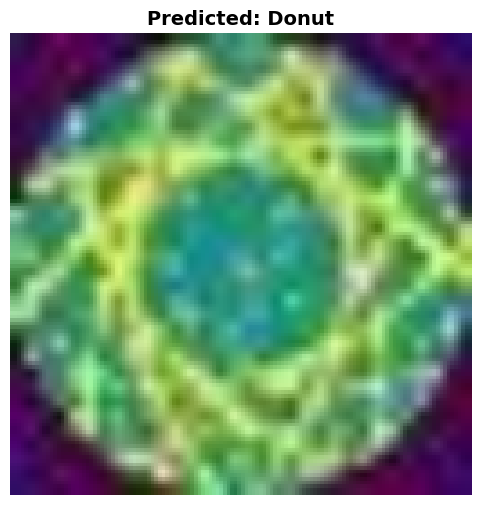

In [ ]:
# Upload new image
uploaded = files.upload()
filename = list(uploaded.keys())[0]
new_img = cv2.imread(filename)
new_img = cv2.resize(new_img, (128, 128))

# Predict
predicted_class, scores = predict_new_image(
    model, scaler, pca, label_encoder,
    new_img, feature_method=feature_method
)

print(f"Predicted class: {predicted_class}")
print(f"Decision scores: {scores}")

# Display image with prediction
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_class}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

In [ ]:
# ============================================
# RANDOM FOREST IMAGE CLASSIFICATION
# Complete Code for Google Colab
# ============================================

# Install libraries
#!pip install scikit-learn opencv-python matplotlib seaborn pillow numpy scikit-image scipy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score)
from sklearn.decomposition import PCA
from skimage.feature import hog
from scipy.stats import randint
from google.colab import files, drive
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("RANDOM FOREST IMAGE CLASSIFICATION - GOOGLE COLAB")
print("="*70)

# ============================================
# DATA LOADING OPTIONS FOR COLAB
# ============================================

def mount_google_drive():
    """
    Mount Google Drive to access your dataset
    """
    print("\n✓ Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✓ Google Drive mounted successfully!")
    print("\nYour dataset path will be: /content/drive/MyDrive/your_dataset_folder")
    return '/content/drive/MyDrive/'

def upload_and_extract_zip():
    """
    Upload a zip file containing your image dataset

    Expected folder structure inside zip:
    dataset.zip
      ├── class1/
      │   ├── image1.jpg
      │   ├── image2.jpg
      ├── class2/
      │   ├── image1.jpg
      │   ├── image2.jpg
    """
    print("\n✓ Upload your dataset ZIP file...")
    uploaded = files.upload()

    zip_filename = list(uploaded.keys())[0]
    print(f"\n✓ Extracting {zip_filename}...")

    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('dataset')

    print("✓ Extraction complete!")

    # Find the extracted folder
    extracted_folders = os.listdir('dataset')
    if len(extracted_folders) == 1:
        dataset_path = os.path.join('dataset', extracted_folders[0])
    else:
        dataset_path = 'dataset'

    return dataset_path

# ============================================
# 1. LOAD IMAGES FROM FOLDER STRUCTURE
# ============================================

def load_images_from_folder(folder_path, img_size=(128, 128), max_images_per_class=None):
    """
    Load images from folder structure:

    folder_path/
      ├── class1/
      │   ├── img1.jpg
      │   ├── img2.jpg
      ├── class2/
      │   ├── img1.jpg
      │   ├── img2.jpg

    Parameters:
    - folder_path: path to main folder containing class subfolders
    - img_size: resize all images to this size (width, height)
    - max_images_per_class: limit number of images per class (None = load all)
    """
    print(f"\n✓ Loading images from: {folder_path}")
    print(f"  Target size: {img_size}")

    images = []
    labels = []
    class_names = []
    image_paths = []

    # Get all class folders
    class_folders = [f for f in os.listdir(folder_path)
                     if os.path.isdir(os.path.join(folder_path, f))]

    if len(class_folders) == 0:
        raise ValueError(f"No class folders found in {folder_path}")

    class_folders.sort()
    print(f"\n  Found {len(class_folders)} classes: {class_folders}")

    # Load images from each class
    for class_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(folder_path, class_name)
        class_names.append(class_name)

        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Limit images per class if specified
        if max_images_per_class:
            image_files = image_files[:max_images_per_class]

        loaded_count = 0
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                # Load and preprocess image
                img = cv2.imread(img_path)
                if img is None:
                    continue

                # Resize image
                img = cv2.resize(img, img_size)

                images.append(img)
                labels.append(class_name)
                image_paths.append(img_path)
                loaded_count += 1

            except Exception as e:
                print(f"  Error loading {img_path}: {e}")

        print(f"  ✓ {class_name}: Loaded {loaded_count} images")

    images = np.array(images)
    labels = np.array(labels)

    print(f"\n✓ Total images loaded: {len(images)}")
    print(f"  Image shape: {images[0].shape}")
    print(f"  Classes: {class_names}")

    return images, labels, class_names, image_paths

# ============================================
# 2. VISUALIZE DATASET
# ============================================

def visualize_dataset(images, labels, class_names, n_samples=16):
    """
    Display sample images from the dataset
    """
    print(f"\n✓ Visualizing {n_samples} random samples...")

    # Select random samples
    indices = np.random.choice(len(images), min(n_samples, len(images)), replace=False)

    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        if i >= rows * cols:
            break

        img = images[idx]
        label = labels[idx]

        # Convert BGR to RGB for display
        if len(img.shape) == 3:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_display = img

        axes[i].imshow(img_display)
        axes[i].set_title(f'{label}', fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, class_names):
    """
    Plot distribution of classes in dataset
    """
    from collections import Counter

    label_counts = Counter(labels)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(label_counts.keys(), label_counts.values(), color='steelblue')
    plt.xlabel('Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
    plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n✓ Class Distribution:")
    for class_name, count in sorted(label_counts.items()):
        print(f"  {class_name}: {count} images")

# ============================================
# 3. FEATURE EXTRACTION FOR IMAGES
# ============================================

def extract_features(images, method='hog'):
    """
    Extract features from images

    Methods:
    - 'hog': Histogram of Oriented Gradients (best for shapes/objects)
    - 'histogram': Color histogram (best for color-based classification)
    - 'combined': Both HOG and histogram
    - 'raw': Raw pixel values (fastest but least accurate)
    """
    print(f"\n✓ Extracting features using '{method}' method...")

    if method == 'hog':
        features = []
        for img in images:
            # Convert to grayscale
            if len(img.shape) == 3:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img

            # Extract HOG features
            feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, feature_vector=True)
            features.append(feat)

        features = np.array(features)

    elif method == 'histogram':
        features = []
        for img in images:
            if len(img.shape) == 3:
                hist_b = cv2.calcHist([img], [0], None, [32], [0, 256])
                hist_g = cv2.calcHist([img], [1], None, [32], [0, 256])
                hist_r = cv2.calcHist([img], [2], None, [32], [0, 256])
                feat = np.concatenate([hist_b, hist_g, hist_r]).flatten()
            else:
                hist = cv2.calcHist([img], [0], None, [32], [0, 256])
                feat = hist.flatten()
            features.append(feat)

        features = np.array(features)

    elif method == 'combined':
        hog_feat = extract_features(images, method='hog')
        hist_feat = extract_features(images, method='histogram')
        features = np.concatenate([hog_feat, hist_feat], axis=1)

    elif method == 'raw':
        features = images.reshape(len(images), -1)

    else:
        raise ValueError("Invalid method. Choose: 'hog', 'histogram', 'combined', 'raw'")

    print(f"  Feature shape: {features.shape}")
    return features

# ============================================
# 4. TRAIN RANDOM FOREST CLASSIFIER
# ============================================

def train_random_forest_basic(X_train, y_train, n_estimators=100, max_depth=20):
    """
    Train a basic Random Forest classifier
    """
    print(f"\n✓ Training Random Forest with {n_estimators} trees...")

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    print(f"  Model trained successfully!")
    return rf_model

def train_random_forest_with_tuning(X_train, y_train, cv=5):
    """
    Train Random Forest with hyperparameter tuning using GridSearchCV
    """
    print(f"\n✓ Training Random Forest with GridSearchCV...")

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

    # Create GridSearchCV object
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    print(f"  ✓ Grid Search Complete!")
    print(f"  Best Parameters: {grid_search.best_params_}")
    print(f"  Best Cross-Validation Score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

def train_random_forest_randomized_search(X_train, y_train, n_iter=20, cv=3):
    """
    Train Random Forest with RandomizedSearchCV (faster than GridSearch)
    """
    print(f"\n✓ Training Random Forest with RandomizedSearchCV...")

    # Define parameter distributions
    param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(5, 50),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', None]
    }

    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    rand_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    rand_search.fit(X_train, y_train)

    print(f"  ✓ Randomized Search Complete!")
    print(f"  Best Parameters: {rand_search.best_params_}")
    print(f"  Best Score: {rand_search.best_score_:.4f}")

    return rand_search.best_estimator_, rand_search.best_params_

# ============================================
# 5. TRAIN ON CUSTOM DATASET
# ============================================

def train_rf_on_custom_dataset(images, labels, class_names,
                                feature_method='hog',
                                use_pca=True,
                                pca_components=100,
                                test_size=0.2,
                                use_tuning=True):
    """
    Complete training pipeline for custom dataset
    """
    print("\n" + "="*70)
    print("TRAINING RANDOM FOREST ON YOUR DATASET")
    print("="*70)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels)

    print(f"\n✓ Classes: {class_names}")
    print(f"  Total samples: {len(images)}")

    # Extract features
    X = extract_features(images, method=feature_method)

    # Split data
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, range(len(X)), test_size=test_size, random_state=42, stratify=y
    )

    print(f"\n✓ Data split:")
    print(f"  Training: {len(X_train)} samples")
    print(f"  Testing: {len(X_test)} samples")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA if needed
    pca = None
    if use_pca and X_train_scaled.shape[1] > pca_components:
        print(f"\n✓ Applying PCA (reducing to {pca_components} components)...")
        pca = PCA(n_components=pca_components)
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)
        print(f"  Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

    # Train Random Forest
    if use_tuning:
        model, best_params = train_random_forest_randomized_search(
            X_train_scaled, y_train, n_iter=20, cv=3
        )
    else:
        model = train_random_forest_basic(X_train_scaled, y_train, n_estimators=100)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\n✓ Training complete!")
    print(f"  Test Accuracy: {accuracy:.4f}")

    # Detailed evaluation
    print("\n" + "="*70)
    print("EVALUATION RESULTS")
    print("="*70)

    print(f"\n✓ Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        print(f"\n✓ Feature Importance Analysis:")
        importances = model.feature_importances_
        print(f"  Top 10 important features: {np.argsort(importances)[-10:][::-1]}")

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        indices = np.argsort(importances)[-20:]
        plt.barh(range(len(indices)), importances[indices])
        plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.xlabel('Importance')
        plt.ylabel('Feature Index')
        plt.tight_layout()
        plt.show()

    # Visualize predictions
    print("\n✓ Visualizing predictions on test set...")
    visualize_predictions(images[idx_test], y_test, y_pred, class_names)

    return model, scaler, pca, label_encoder, X_test_scaled, y_test, y_pred, idx_test

def visualize_predictions(test_images, y_true, y_pred, class_names, n_samples=16):
    """
    Visualize predictions on test images
    """
    indices = np.random.choice(len(test_images), min(n_samples, len(test_images)), replace=False)

    rows = 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        if i >= rows * cols:
            break

        img = test_images[idx]
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        # Convert BGR to RGB
        if len(img.shape) == 3:
            img_display = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img_display = img

        axes[i].imshow(img_display)

        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                         color=color, fontsize=9, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================
# 6. PREDICT NEW IMAGES
# ============================================

def predict_new_image(model, scaler, pca, label_encoder,
                     new_image, feature_method='hog'):
    """
    Predict class for a new image
    """
    # Ensure image is in correct format
    if len(new_image.shape) == 2:
        new_image = cv2.cvtColor(new_image, cv2.COLOR_GRAY2BGR)

    # Extract features
    features = extract_features(np.array([new_image]), method=feature_method)

    # Scale
    features_scaled = scaler.transform(features)

    # Apply PCA if used during training
    if pca is not None:
        features_scaled = pca.transform(features_scaled)

    # Predict
    prediction = model.predict(features_scaled)[0]
    prediction_proba = model.predict_proba(features_scaled)[0]

    class_name = label_encoder.inverse_transform([prediction])[0]

    return class_name, prediction_proba

# ============================================
# 7. COMPARE MULTIPLE FEATURE METHODS
# ============================================

def compare_feature_methods(images, labels, class_names):
    """
    Compare different feature extraction methods
    """
    print("\n" + "="*70)
    print("COMPARING FEATURE EXTRACTION METHODS")
    print("="*70)

    methods = ['hog', 'histogram', 'combined']
    results = {}

    for method in methods:
        print(f"\n### Testing {method.upper()} features ###")

        # Extract features
        X = extract_features(images, method=method)

        # Encode labels
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(labels)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train
        model = train_random_forest_basic(X_train_scaled, y_train)

        # Evaluate
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

        results[method] = accuracy
        print(f"  Accuracy: {accuracy:.4f}")

    # Plot comparison
    plt.figure(figsize=(10, 6))
    methods_list = list(results.keys())
    accuracies = list(results.values())

    bars = plt.bar(methods_list, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.xlabel('Feature Method', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Random Forest Performance: Feature Method Comparison',
              fontsize=14, fontweight='bold')
    plt.ylim([0, 1.0])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontweight='bold')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results

# ============================================
# 8. MAIN EXECUTION PIPELINE
# ============================================

def run_complete_pipeline():
    """
    Complete pipeline for custom dataset
    """
    print("\n" + "#"*70)
    print("# RANDOM FOREST IMAGE CLASSIFICATION PIPELINE")
    print("#"*70)

    # Choose data loading method
    print("\n" + "="*70)
    print("STEP 1: CHOOSE DATA LOADING METHOD")
    print("="*70)
    print("\nSelect one option:")
    print("1. Upload ZIP file (recommended for medium datasets)")
    print("2. Mount Google Drive (recommended for large datasets)")
    print("3. Enter folder path directly (if already uploaded)")

    choice = input("\nEnter your choice (1/2/3): ").strip()

    if choice == '1':
        dataset_path = upload_and_extract_zip()
    elif choice == '2':
        drive_path = mount_google_drive()
        folder_name = input("\nEnter your dataset folder name in Google Drive: ").strip()
        dataset_path = os.path.join(drive_path, folder_name)
    elif choice == '3':
        dataset_path = input("\nEnter full path to your dataset folder: ").strip()
    else:
        print("Invalid choice. Using default path: /content/dataset")
        dataset_path = '/content/dataset'

    # Check if path exists
    if not os.path.exists(dataset_path):
        print(f"\n✗ Error: Path not found: {dataset_path}")
        return None

    # Load images
    images, labels, class_names, image_paths = load_images_from_folder(
        dataset_path,
        img_size=(128, 128),
        max_images_per_class=None
    )

    # Visualize dataset
    visualize_dataset(images, labels, class_names, n_samples=16)
    plot_class_distribution(labels, class_names)

    # Choose feature method
    print("\n" + "="*70)
    print("Choose feature extraction method:")
    print("  1. HOG (best for shapes/objects) - RECOMMENDED")
    print("  2. Histogram (best for colors)")
    print("  3. Combined (HOG + Histogram)")
    print("  4. Raw pixels (fastest)")
    feature_choice = input("\nChoice (1-4) [1]: ").strip() or '1'

    feature_map = {'1': 'hog', '2': 'histogram', '3': 'combined', '4': 'raw'}
    feature_method = feature_map.get(feature_choice, 'hog')

    # Train model
    model, scaler, pca, label_encoder, X_test, y_test, y_pred, test_idx = train_rf_on_custom_dataset(
        images, labels, class_names,
        feature_method=feature_method,
        use_pca=True,
        pca_components=100,
        test_size=0.2,
        use_tuning=True
    )

    # Optional: Compare methods
    compare = input("\nCompare different feature methods? (y/n) [n]: ").strip().lower()
    if compare == 'y':
        compare_feature_methods(images, labels, class_names)

    print("\n" + "="*70)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*70)

    return model, scaler, pca, label_encoder, feature_method, class_names

# ============================================
# RUN THE PIPELINE
# ============================================

# Run complete pipeline
model, scaler, pca, label_encoder, feature_method, class_names = run_complete_pipeline()

print("\n✅ Your Random Forest model is ready!")
print("\nTo predict a new image:")
print("""
# Upload new image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load and predict
new_img = cv2.imread(img_path)
new_img = cv2.resize(new_img, (128, 128))

predicted_class, probabilities = predict_new_image(
    model, scaler, pca, label_encoder,
    new_img, feature_method=feature_method
)

print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

# Display
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted: {predicted_class}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
""")
